### Redes Neurais Artificiais
### Professor Ciniro Nametala - IFMG
### Aluno Víctor Hordones Ramos - IFMG

## Classificação de objetos que encontrei com Redes Neurais Convolucionais (CNN)

Neste trabalho vamos construir um classificador de objetos utilizando Redes Neurais Convolucionais (CNN). O projeto é dividido em três etapas principais:

1. **Captura de imagens**: Utilizando a webcam, há uma captura de imagens dos objetos.
2. **Treinamento da CNN**: Uma rede neural convolucional é treinada para reconhecer um objeto.
3. **Predição ao vivo**: O modelo treinado é utilizado para classificar os objetos em tempo real através da webcam.

As imagens são capturadas em escala de cinza com resolução configurável de nxn pixels. O modelo utiliza camadas convolucionais para extrair características das imagens e camadas densas para classificação.

**Classes do modelo:**
- PINÇA (0)
- TOALHINHA (1)
- GARRAFA (2)
- ALICATE (3)
- CELULAR (4)
- ESTOJO (5)
- FOLHA A4 (6)
- MONITOR (7)
- CLIP (8)
- CORRETIVO (9)
- NÃO TEM IDEIA (quando confiança < 60%)

## 1. Preparação do ambiente

In [1]:
#funcao para deixar o jupyter com celulas preenchendo toda a tela
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#cria as pastas para armazenar o dataset e os modelos treinados
import os
os.makedirs("dataset", exist_ok=True)
os.makedirs("models", exist_ok=True)

### 1.1 Importação de pacotes

In [45]:
#para exportar o requeriments
import subprocess
import sys

#bibliotecas para trabalhar com dados e graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

#bibliotecas do scikit-learn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#biblioteca para exportacoes e importacoes de arquivos
from joblib import dump, load

#biblioteca para implementar uma barra de progresso
import progressbar

#biblioteca para tocar sons
import pygame

#bibliotecas para captura de imagens
import os
import cv2
import time
import glob
import shutil

#bibliotecas para deep learning
import tensorflow.keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#bibliotecas para plotar graficos do keras
import pydot as pyd
from tensorflow.keras.utils import plot_model, model_to_dot
tensorflow.keras.utils.pydot = pyd

### 1.2 Verificando versões

In [4]:
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

print(f"Pandas version: {pd.__version__}")

import matplotlib
print(f"Matplotlib version: {matplotlib.__version__}")

print(f"Seaborn version: {sns.__version__}")
print(f"OpenCV version: {cv2.__version__}")

Python version: 3.11.14 (main, Oct 21 2025, 18:31:21) [GCC 11.2.0]
NumPy version: 1.26.4
TensorFlow version: 2.15.0
Pandas version: 2.3.3
Matplotlib version: 3.10.6
Seaborn version: 0.13.2
OpenCV version: 4.9.0


### 1.3 Checagem de GPU

In [5]:
#verificacao de GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow encontrou GPUs: {len(gpus) > 0}")
print(f"Dispositivos GPU TensorFlow: {gpus}")

TensorFlow encontrou GPUs: True
Dispositivos GPU TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2026-01-22 18:49:49.397222: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-22 18:49:49.605369: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-22 18:49:49.605651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## 2. Configurações do experimento

In [6]:
#------------------------------
#CONFIGURACOES DE CAPTURA
#------------------------------

#tempo de captura em segundos
capture_time = 10

#quantidade de fotos por classe
capture_count = 50

#resolucao das imagens (quadradas)
img_size = 128

#tamanho da area de captura na tela (em pixels)
box_size = 400

#realizar nova captura (True) ou usar capturas existentes (False)
#se True, apaga o conteudo da pasta 'captura' e tira novas fotos
#se False, usa as fotos existentes na pasta 'captura'
new_capture = True

#------------------------------
#CONFIGURACOES DE TREINAMENTO
#------------------------------

#gerar um novo modelo ou usar um pronto
new_model = True

#realizar data augmentation (rotacao, zoom, flip)
augmentation_exec = True

#realizar escalonamento de dados (escala 0-1)
normalization_exec = True

#threshold de confianca para classificar como NEUTRO
confidence_threshold = 0.60

#nome do modelo
model_name = 'cnn_classificacao_objetos'

#classes do modelo
class_names = ['PINCA', 'TOALHINHA', 'GARRAFA', 'ALICATE', 'CELULAR', 
               'ESTOJO', 'FOLHA_A4', 'MONITOR', 'CLIP', 'CORRETIVO']
num_classes = len(class_names)

## 3. Captura de imagens

### 3.1 Funções auxiliares de captura

In [ ]:
def prepare_capture_folder(base_path='dataset'):
    """prepara a pasta de captura"""
    folder_path = os.path.join(base_path, 'captura')

    #se a pasta existe, apaga e recria
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f'pasta {folder_path} apagada')
    
    os.makedirs(folder_path)
    print(f'pasta {folder_path} criada')
    return folder_path

def capture_images(class_name, num_images, capture_seconds, img_size, box_size, save_path):
    """captura imagens da webcam com countdown e preview"""
    
    #usa o backend AVFoundation no macOS para evitar crash
    if sys.platform == 'darwin':
        cap = cv2.VideoCapture(0, cv2.CAP_AVFOUNDATION)
    else:
        cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print('erro: nao foi possivel abrir a webcam')
        return False

    #calcula intervalo entre capturas
    interval = capture_seconds / num_images

    print(f'\n=== capturando {class_name.upper()} ===')
    print(f'posicione-se em {class_name.upper()} e pressione SPACE para iniciar...')
    print('pressione Q para cancelar')
    
    window_name = 'Captura'
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)

    try:
        #aguarda usuario pressionar space para iniciar
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            #espelha a imagem para facilitar posicionamento
            frame = cv2.flip(frame, 1)

            #adiciona texto de instrucao
            cv2.putText(frame, f'Posicione-se em {class_name.upper()}', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(frame, 'Pressione SPACE para iniciar', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            #desenha area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2),
                        (cx + box_size//2, cy + box_size//2), (0, 255, 0), 2)

            cv2.imshow(window_name, frame)

            key = cv2.waitKey(1) & 0xFF
            if key == ord(' '):
                break
            elif key == ord('q'):
                cap.release()
                cv2.destroyWindow(window_name)
                cv2.waitKey(1)
                return False

        #inicia captura com countdown
        start_time = time.time()
        images_captured = 0
        last_capture_time = 0

        while images_captured < num_images:
            ret, frame = cap.read()
            if not ret:
                break

            #espelha a imagem
            frame = cv2.flip(frame, 1)

            elapsed = time.time() - start_time
            remaining = max(0, capture_seconds - elapsed)

            #desenha area de captura
            h, w = frame.shape[:2]
            cx, cy = w // 2, h // 2
            cv2.rectangle(frame, (cx - box_size//2, cy - box_size//2),
                        (cx + box_size//2, cy + box_size//2), (0, 0, 255), 2)

            #adiciona countdown e contador de fotos
            cv2.putText(frame, f'Tempo: {remaining:.1f}s', (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'Fotos: {images_captured}/{num_images}', (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, f'{class_name.upper()}', (10, 90),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            cv2.imshow(window_name, frame)

            #captura imagem no intervalo correto
            if elapsed - last_capture_time >= interval:
                #extrai regiao de interesse (ROI)
                roi = frame[cy - box_size//2:cy + box_size//2,
                            cx - box_size//2:cx + box_size//2]

                #converte para escala de cinza
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

                #redimensiona para tamanho desejado
                roi_resized = cv2.resize(roi_gray, (img_size, img_size))

                #salva imagem
                filename = os.path.join(save_path, f'{class_name}_{images_captured + 1:03d}.jpg')
                cv2.imwrite(filename, roi_resized)

                images_captured += 1
                last_capture_time = elapsed

            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

            if elapsed >= capture_seconds and images_captured >= num_images:
                break

    finally:
        #libera a camera e fecha a janela de forma segura
        cap.release()
        cv2.destroyWindow(window_name)
        #processa eventos pendentes
        for _ in range(10):
            cv2.waitKey(1)
        time.sleep(0.5)

    print(f'{images_captured} imagens de {class_name.upper()} capturadas')
    return True

### 3.2 Execução da captura

In [ ]:
#executa captura se new_capture=True
if new_capture:
    capture_path = prepare_capture_folder()
    
    print('\n' + '='*50)
    print('INICIANDO CAPTURA DE IMAGENS')
    print('='*50)
    print(f'tempo por classe: {capture_time} segundos')
    print(f'fotos por classe: {capture_count}')
    print(f'area de captura: {box_size}x{box_size} pixels')
    print(f'resolucao final: {img_size}x{img_size} pixels (escala de cinza)')
    print('='*50)
    
    #captura cada classe
    for class_name in class_names:
        success = capture_images(class_name, capture_count, capture_time, img_size, box_size, capture_path)
        if not success:
            print(f'captura de {class_name} cancelada')
            break
        time.sleep(1)  #pequena pausa entre capturas
    
    print('\n' + '='*50)
    print('CAPTURA FINALIZADA')
    print('='*50)
else:
    capture_path = os.path.join('dataset', 'captura')
    if os.path.exists(capture_path):
        print(f'usando dataset existente: {capture_path}')
    else:
        print(f'erro: pasta {capture_path} nao encontrada')
        print('defina new_capture=True para criar uma nova captura')

## 4. Análise de dados

### 4.1 Carregamento das imagens

In [7]:
def load_images(folder_path, class_names, img_size):
    """carrega imagens e retorna arrays de dados e rotulos"""
    images = []
    labels = []
    
    for idx, class_name in enumerate(class_names):
        pattern = os.path.join(folder_path, f'{class_name}_*.jpg')
        files = glob.glob(pattern)
        
        print(f'{class_name}: {len(files)} imagens encontradas')
        
        for file in files:
            img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                images.append(img)
                labels.append(idx)
    
    return np.array(images), np.array(labels)

#carrega as imagens
capture_path = os.path.join('dataset', 'captura')
x_data, y_data = load_images(capture_path, class_names, img_size)

print(f'\ntotal de imagens: {len(x_data)}')
print(f'shape dos dados: {x_data.shape}')
print(f'shape dos rotulos: {y_data.shape}')

PINCA: 50 imagens encontradas
TOALHINHA: 50 imagens encontradas
GARRAFA: 50 imagens encontradas
ALICATE: 50 imagens encontradas
CELULAR: 50 imagens encontradas
ESTOJO: 50 imagens encontradas
FOLHA_A4: 50 imagens encontradas
MONITOR: 50 imagens encontradas
CLIP: 50 imagens encontradas
CORRETIVO: 50 imagens encontradas

total de imagens: 500
shape dos dados: (500, 128, 128)
shape dos rotulos: (500,)


### 4.2 Visualização das amostras

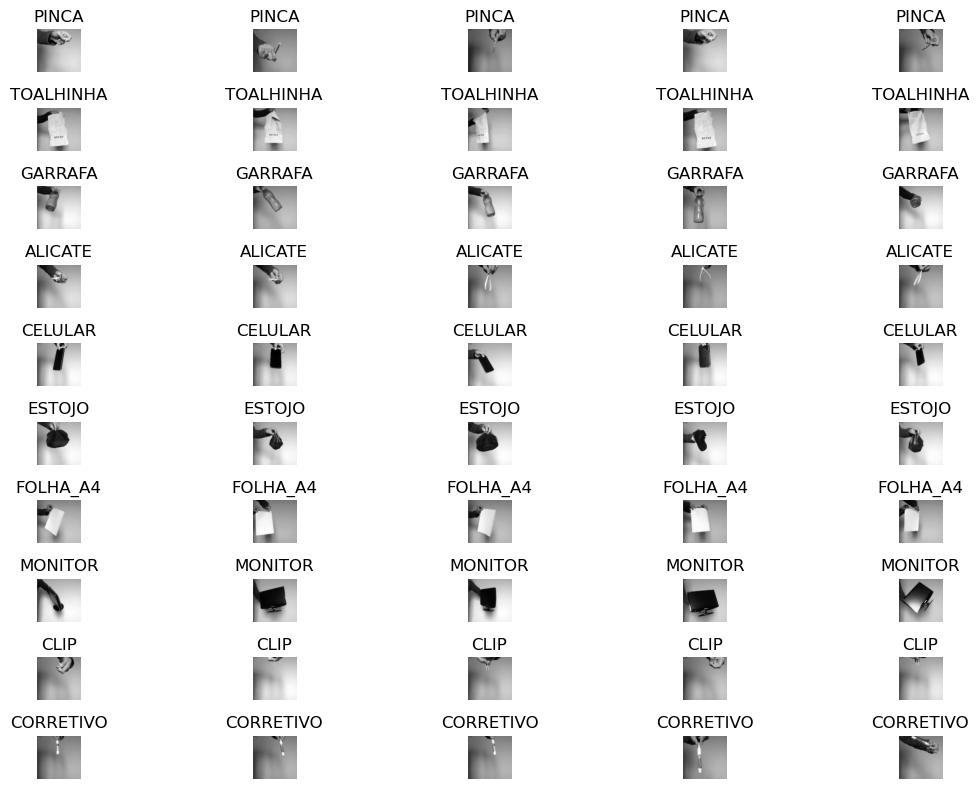

In [8]:
#visualiza algumas amostras de cada classe
fig, axs = plt.subplots(num_classes, 5, figsize=(12, 8))

for i, class_name in enumerate(class_names):
    class_indices = np.where(y_data == i)[0]
    sample_indices = np.random.choice(class_indices, min(5, len(class_indices)), replace=False)
    
    for j, idx in enumerate(sample_indices):
        axs[i, j].imshow(x_data[idx], cmap='gray')
        axs[i, j].set_title(f'{class_name}')
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### 4.3 Sumarização estatística

In [9]:
def sumarizacao(x_data, y_data, class_names):
    stats = []

    for idx, class_name in enumerate(class_names):
        class_data = x_data[y_data == idx]
        
        count = len(class_data)
        mean_pixel = round(np.mean(class_data), 2)
        std_pixel = round(np.std(class_data), 2)
        min_pixel = round(np.min(class_data), 2)
        max_pixel = round(np.max(class_data), 2)
        
        stats.append([class_name, count, mean_pixel, std_pixel, min_pixel, max_pixel])

    headers = ['Classe', 'Quantidade', 'Média Pixel', 'Desvio Padrão', 'Mínimo', 'Máximo']

    table = tabulate(stats, headers, tablefmt="pipe")
    print(table)

sumarizacao(x_data, y_data, class_names)

| Classe    |   Quantidade |   Média Pixel |   Desvio Padrão |   Mínimo |   Máximo |
|:----------|-------------:|--------------:|----------------:|---------:|---------:|
| PINCA     |           50 |        128.93 |           38.35 |        7 |      255 |
| TOALHINHA |           50 |        133.3  |           34.12 |        9 |      197 |
| GARRAFA   |           50 |        134.03 |           33.89 |       10 |      240 |
| ALICATE   |           50 |        135.89 |           32.94 |        9 |      255 |
| CELULAR   |           50 |        135.51 |           41.36 |        8 |      226 |
| ESTOJO    |           50 |        131.72 |           49.51 |        9 |      202 |
| FOLHA_A4  |           50 |        132.81 |           41.24 |       10 |      222 |
| MONITOR   |           50 |        129.98 |           58.8  |        9 |      255 |
| CLIP      |           50 |        135.26 |           30.02 |       11 |      255 |
| CORRETIVO |           50 |        135.05 |           37.23 |   

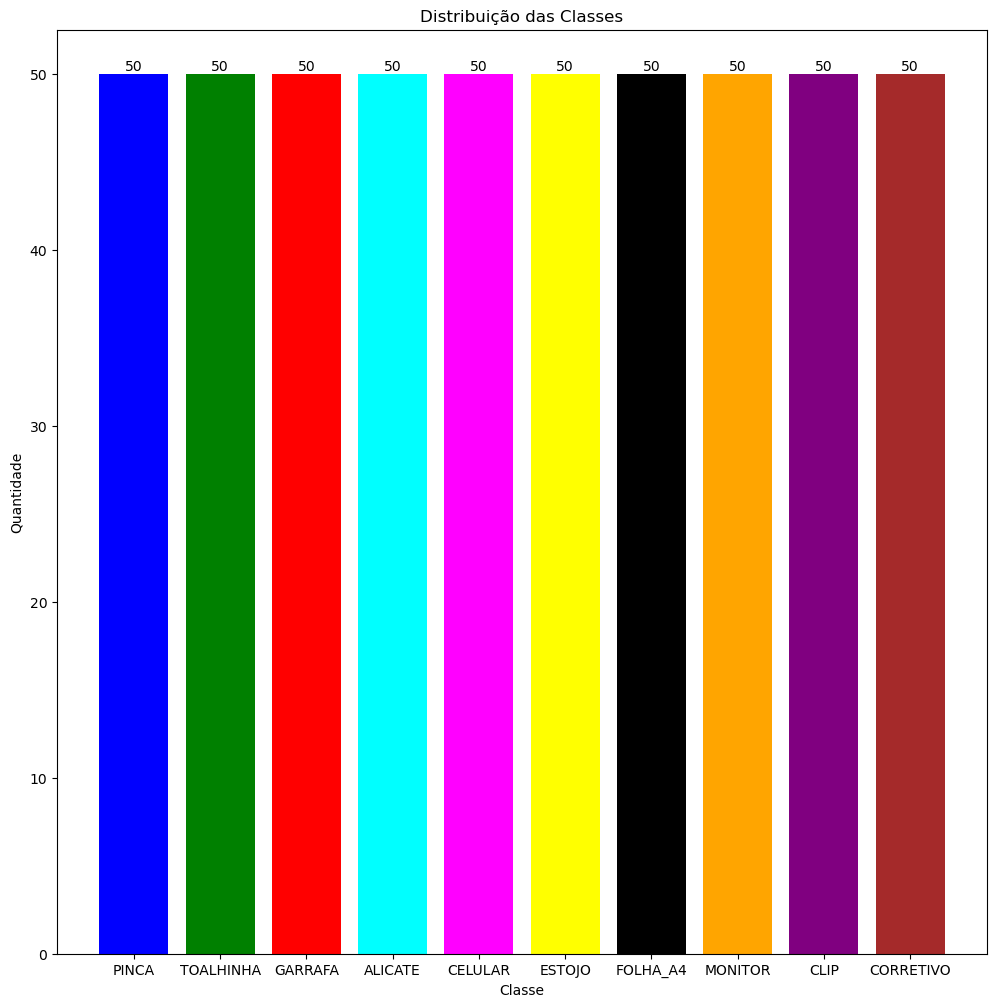

In [10]:
#distribuicao das classes
unique, counts = np.unique(y_data, return_counts=True)

plt.figure(figsize=(12, 12))
plt.bar([class_names[i] for i in unique], counts, color=['blue','green', 'red', 'cyan', 'magenta', 
                                                           'yellow', 'black', 'orange', 'purple', 'brown'])
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.title('Distribuição das Classes')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

### 4.4 Pré-processamento dos dados

In [11]:
#adiciona dimensao do canal (escala de cinza = 1 canal)
x_data = x_data.reshape(x_data.shape[0], img_size, img_size, 1)

#normalizacao (escala 0-1)
if normalization_exec:
    x_data = x_data.astype('float32') / 255.0
    print('dados normalizados para escala [0, 1]')

#converte rotulos para one-hot encoding
y_data_cat = to_categorical(y_data, num_classes)

print(f'shape dos dados: {x_data.shape}')
print(f'shape dos rotulos (one-hot): {y_data_cat.shape}')
#150 dados para 3 saídas

dados normalizados para escala [0, 1]
shape dos dados: (500, 128, 128, 1)
shape dos rotulos (one-hot): (500, 10)


## 5. Separação dos conjuntos de dados (treino, validação e teste)

In [12]:
#separa treino+validacao e teste
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x_data, y_data_cat, test_size=0.2, shuffle=True, random_state=42, stratify=y_data_cat
)

#separa treino e validacao
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.25, shuffle=True, random_state=42, stratify=y_train_val
)

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (300, 128, 128, 1)
y_train shape: (300, 10)
x_val shape: (100, 128, 128, 1)
y_val shape: (100, 10)
x_test shape: (100, 128, 128, 1)
y_test shape: (100, 10)


### 5.1 Data Augmentation (opcional)

data augmentation configurado


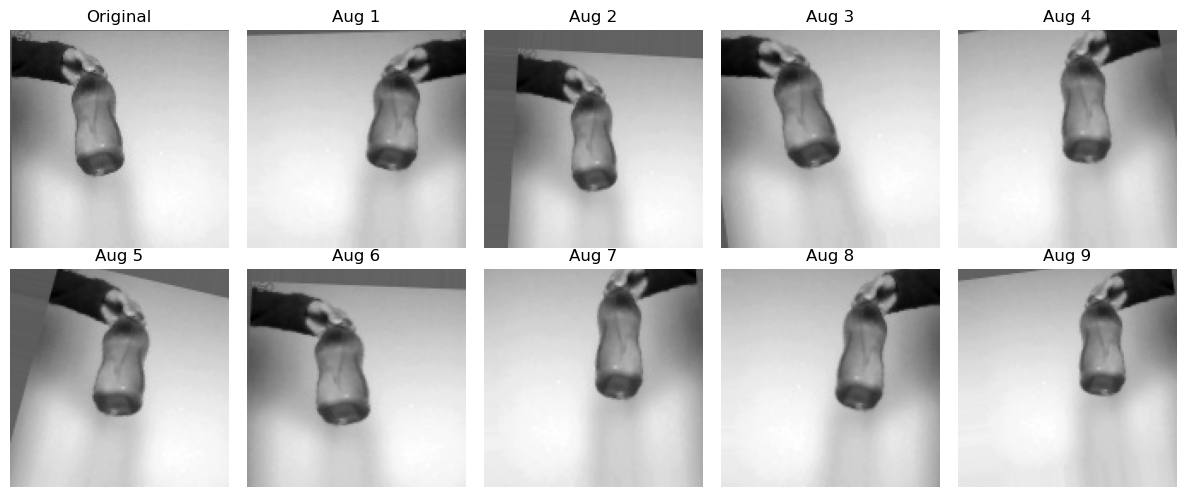

In [13]:
#configura data augmentation - aplica rotações, zoom, 
if augmentation_exec:
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    datagen.fit(x_train)
    print('data augmentation configurado')
    
    #visualiza exemplos de augmentation
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    sample_img = x_train[0:1]
    
    axs[0, 0].imshow(sample_img[0].reshape(img_size, img_size), cmap='gray')
    axs[0, 0].set_title('Original')
    axs[0, 0].axis('off')
    
    for i, batch in enumerate(datagen.flow(sample_img, batch_size=1)):
        if i >= 9:
            break
        row = (i + 1) // 5
        col = (i + 1) % 5
        axs[row, col].imshow(batch[0].reshape(img_size, img_size), cmap='gray')
        axs[row, col].set_title(f'Aug {i+1}')
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    datagen = None
    print('data augmentation desativado')

## 6. Treinamento do modelo

### 6.1 Construção do modelo

In [23]:
#empilhamento de camadas para construir uma CNN

act_function = 'relu'
act_function_out = 'softmax' #soma as saidas da relu e divide pelo valor relu/softmax
#transforma em escala percentual
#softmax - pega a saida de qualquer neuronio e transforma em porcentagem - ate dar 100% em um neuronio
drop = 0.25
initializer = tensorflow.keras.initializers.HeNormal()

#entrada
inputs = Input(shape=(img_size, img_size, 1), dtype='float32', name='input')
#1 - uma imagem entra por vez - o ultimo 1 no shape

#bloco convolucional 1
conv1 = Conv2D(32, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(inputs)
#32 kernels (tamanho do kernel), stride 1 e padding 1
conv1 = BatchNormalization()(conv1) #ajusta os valores se ficarem muito ruins da camada de conv1
conv1 = Conv2D(32, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
drop1 = Dropout(drop)(pool1) #25% das vezes nao vai haver uma atualizacao do kernel - por causa do dropout de 0.25

#bloco convolucional 2
conv2 = Conv2D(64, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(drop1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop2 = Dropout(drop)(pool2)

#bloco convolucional 3
conv3 = Conv2D(128, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(drop2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation=act_function, padding='same', kernel_initializer=initializer)(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
drop3 = Dropout(drop)(pool3)

#camadas densas
flat = Flatten()(drop3) #achata as linhas da matriz para um vetor
dense1 = Dense(256, activation=act_function, kernel_initializer=initializer)(flat)
dense1 = BatchNormalization()(dense1)
drop4 = Dropout(0.5)(dense1)

#saida
outputs = Dense(num_classes, activation=act_function_out, name='output')(drop4)

#geracao do modelo
cnn_model = Model(inputs, outputs, name=model_name)

/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


### 6.2 Inspecionando o modelo

In [20]:
cnn_model.summary()

Model: "cnn_classificacao_objetos"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_7 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_8 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 6

In [ ]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True, rankdir="TB")

In [21]:
print('x_train type:', type(x_train))
print('y_train type:', type(y_train))
print('x_train dtype:', x_train.dtype)
print('y_train dtype:', y_train.dtype)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
x_train dtype: float32
y_train dtype: float32
x_train shape: (300, 128, 128, 1)
y_train shape: (300, 10)


### 6.3 Otimização do modelo

In [26]:
if new_model:
    
    opt = Adam(learning_rate=0.0001)
    
    cnn_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    cp = ModelCheckpoint(
        filepath='models/best_model.weights.h5',
        save_weights_only=True,
        monitor='val_loss', #vai salvar os melhores pesos baseados na validacao
        mode='min', #salvando o que da o minimo erro
        save_best_only=True
    )
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,        
        patience=10,       
        min_lr=1e-7,       
        verbose=1
    )
    
    if augmentation_exec and datagen is not None:
        #treina com data augmentation
        history = cnn_model.fit(
            datagen.flow(x_train, y_train, batch_size=8),
            #batch_size - quantidade de erros acumulados para depois aplicar o backpropagation
            #nesse caso - acumula 8 vezes e faz a media 
            validation_data=(x_val, y_val),
            epochs=300,
            verbose=1,
            callbacks=[es, cp, reduce_lr],
            steps_per_epoch=len(x_train) // 8
        )
    else:
        #treina sem data augmentation
        history = cnn_model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=300,
            verbose=1,
            callbacks=[es, cp],
            batch_size=8,
            shuffle=True
        )
    
    np.save('models/history_model.npy', history.history)
    cnn_model.load_weights('models/best_model.weights.h5')
    cnn_model.save('models/' + model_name + '.h5')
    
else:
    cnn_model = load_model('models/' + model_name + '.h5')

Epoch 1/300


2026-01-22 19:43:05.824728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incnn_classificacao_objetos/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


37/37 [==============================] - 4s 46ms/step - loss: 0.0616 - accuracy: 0.9829 - val_loss: 0.0187 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/300
37/37 [==============================] - 1s 35ms/step - loss: 0.0694 - accuracy: 0.9897 - val_loss: 0.0339 - val_accuracy: 0.9900 - lr: 1.0000e-04
Epoch 3/300
37/37 [==============================] - 1s 35ms/step - loss: 0.1160 - accuracy: 0.9658 - val_loss: 0.1396 - val_accuracy: 0.9800 - lr: 1.0000e-04
Epoch 4/300
37/37 [==============================] - 1s 35ms/step - loss: 0.1012 - accuracy: 0.9658 - val_loss: 0.0705 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 5/300
37/37 [==============================] - 1s 35ms/step - loss: 0.0723 - accuracy: 0.9760 - val_loss: 0.0555 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 6/300
37/37 [==============================] - 1s 35ms/step - loss: 0.0991 - accuracy: 0.9692 - val_loss: 0.2229 - val_accuracy: 0.9500 - lr: 1.0000e-04
Epoch 7/300
37/37 [==============================] - 2s 42

/home/victor/anaconda3/envs/dl_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
#toca um som para avisar que terminou de executar
pygame.mixer.init()
arquivo_mp3 = 'support_files/uepa.mp3'

if os.path.exists(arquivo_mp3):
    pygame.mixer.music.load(arquivo_mp3)
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        continue

print('Sucesso!')

Sucesso!


### 6.4 Avaliação do modelo com curva de convergência

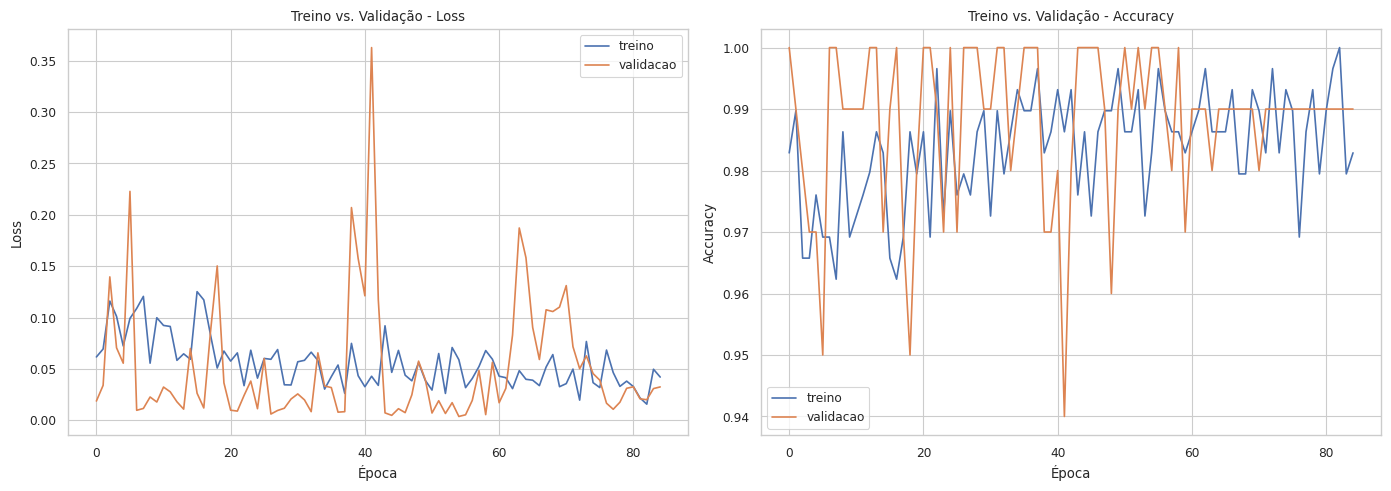

In [38]:
path_model = 'models/v2/history_model.npy'
history = np.load(path_model, allow_pickle='TRUE').item()

sns.set(rc={'figure.figsize':(12, 6)})
sns.set_style('whitegrid')
sns.set_context('paper')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

#grafico de loss
ax1.plot(history['loss'], label='treino')
ax1.plot(history['val_loss'], label='validacao')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Época')
ax1.set_title('Treino vs. Validação - Loss')
ax1.legend()

#grafico de accuracy
ax2.plot(history['accuracy'], label='treino')
ax2.plot(history['val_accuracy'], label='validacao')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Época')
ax2.set_title('Treino vs. Validação - Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

## 7. Testando as previsões

### 7.1 Gerando as previsões com o modelo treinado

In [39]:
#realiza predicoes no conjunto de teste
y_pred_prob = cnn_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f'predicoes realizadas: {len(y_pred)}')

4/4 [==============================] - 0s 20ms/step
predicoes realizadas: 100


### 7.2 Calculando a taxa de acerto com base na matriz de confusão

In [40]:
#calculando a matriz de confusao
cm = confusion_matrix(y_true, y_pred)

#calculando a taxa de acerto
accuracy = np.trace(cm) / cm.sum()
accuracy_percent = round(accuracy * 100, 2)
print(f"Taxa de Acerto: {accuracy_percent:.2f}%")

Taxa de Acerto: 100.00%


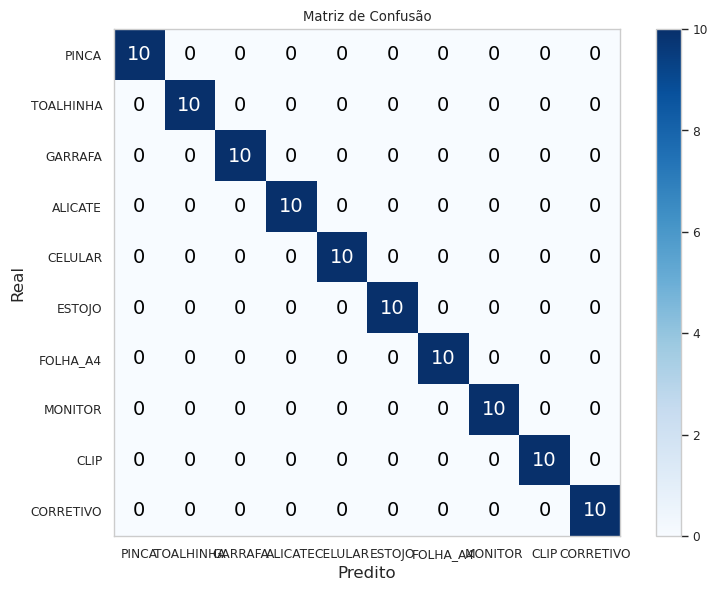

In [41]:
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.imshow(cm, cmap='Blues')

plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusão')

#adiciona rotulos dos eixos
plt.xticks(range(num_classes), class_names)
plt.yticks(range(num_classes), class_names)

threshold = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = 'white' if cm[i, j] > threshold else 'black'
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color=color, fontsize=14)

plt.colorbar()
plt.tight_layout()
plt.show()

### 7.3 Visualização das predições

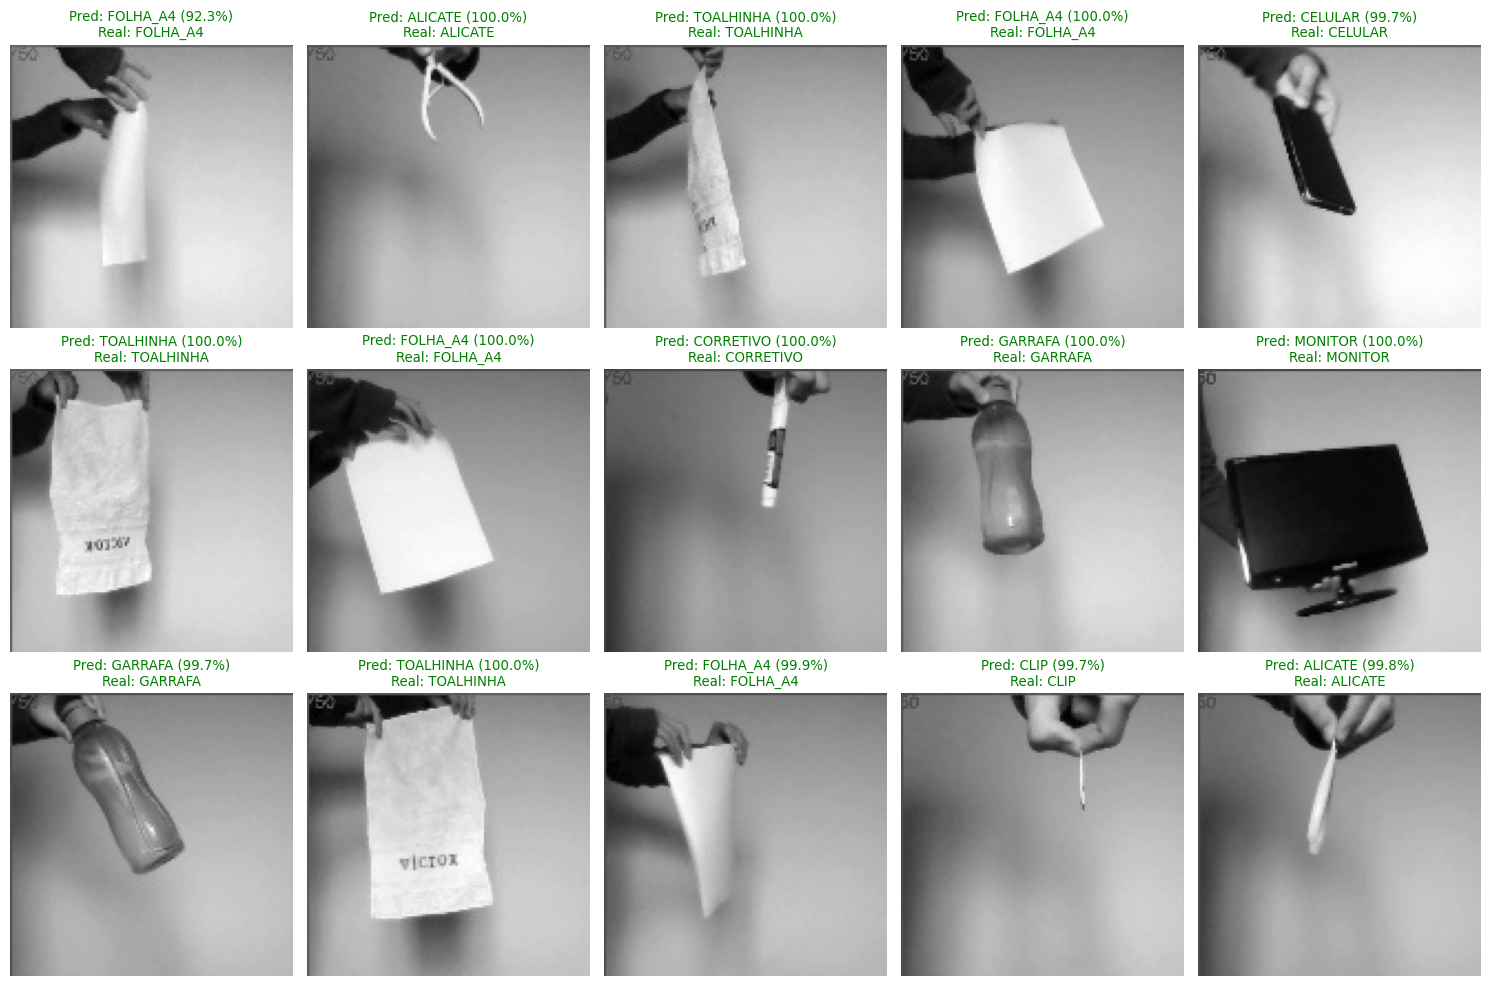

In [42]:
#visualiza algumas predicoes
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

indices = np.random.choice(len(x_test), 15, replace=False)

for i, idx in enumerate(indices):
    row = i // 5
    col = i % 5
    
    axs[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap='gray')
    
    pred_class = class_names[y_pred[idx]]
    true_class = class_names[y_true[idx]]
    confidence = y_pred_prob[idx][y_pred[idx]] * 100
    
    color = 'green' if y_pred[idx] == y_true[idx] else 'red'
    axs[row, col].set_title(f'Pred: {pred_class} ({confidence:.1f}%)\nReal: {true_class}', color=color)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## 8. Perguntas e respostas

### 1. Qual a acurácia nos conjuntos de treino, validação e teste?



In [49]:
print("\n" + "=" * 60)
print("1. ACURÁCIA NOS CONJUNTOS DE DADOS")
print("=" * 60)

# Predições
y_train_pred = cnn_model.predict(x_train, verbose=0)
y_val_pred = cnn_model.predict(x_val, verbose=0)
y_test_pred = cnn_model.predict(x_test, verbose=0)

# Converter de one-hot para classes
y_train_true = np.argmax(y_train, axis=1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

y_val_true = np.argmax(y_val, axis=1)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

y_test_true = np.argmax(y_test, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calcular acurácias
acc_train = accuracy_score(y_train_true, y_train_pred_classes)
acc_val = accuracy_score(y_val_true, y_val_pred_classes)
acc_test = accuracy_score(y_test_true, y_test_pred_classes)

# Avaliar com o método evaluate
loss_train, acc_train_eval = cnn_model.evaluate(x_train, y_train, verbose=0)
loss_val, acc_val_eval = cnn_model.evaluate(x_val, y_val, verbose=0)
loss_test, acc_test_eval = cnn_model.evaluate(x_test, y_test, verbose=0)

print(f"\n📊 ACURÁCIA POR CONJUNTO:")
print(f"  • Treino:     {acc_train*100:.2f}% (Loss: {loss_train:.4f})")
print(f"  • Validação:  {acc_val*100:.2f}% (Loss: {loss_val:.4f})")
print(f"  • Teste:      {acc_test*100:.2f}% (Loss: {loss_test:.4f})")

print(f"\n📈 TAMANHO DOS CONJUNTOS:")
print(f"  • Treino:     {len(x_train)} imagens")
print(f"  • Validação:  {len(x_val)} imagens")
print(f"  • Teste:      {len(x_test)} imagens")


1. ACURÁCIA NOS CONJUNTOS DE DADOS

📊 ACURÁCIA POR CONJUNTO:
  • Treino:     99.67% (Loss: 0.0211)
  • Validação:  100.00% (Loss: 0.0037)
  • Teste:      100.00% (Loss: 0.0100)

📈 TAMANHO DOS CONJUNTOS:
  • Treino:     300 imagens
  • Validação:  100 imagens
  • Teste:      100 imagens


### 2. Como foi a evolução do erro e da acurácia ao longo do processo de treinamento?

##### 📈 EVOLUÇÃO DO TREINAMENTO (Modelo Otimizado)

---

##### **Fase 1: Aprendizado Rápido (Épocas 1-20)**
* **Val_Loss:** 2.46 → 0.17 (queda acentuada)
* **Val_Accuracy:** 10% → 94% (crescimento explosivo)
* **Análise:** A rede aprende os padrões básicos e características globais das imagens rapidamente nesta etapa inicial.

##### **Fase 2: Refinamento (Épocas 20-40)**
* **Ajuste de Hiperparâmetros:** O `ReduceLROnPlateau` reduziu o *Learning Rate* (LR) pela primeira vez na época 17.
* **Val_Accuracy:** Estabilização em patamares elevados (99% – 100%).
* **Val_Loss:** Oscilações controladas entre 0.006 e 0.20.
* **Análise:** Início do ajuste fino (*fine-tuning*) dos pesos, permitindo que o modelo capture detalhes mais sutis.

##### **Fase 3: Convergência (Épocas 40-85)**
* **Gerenciamento de LR:** Reduções sucessivas da taxa de aprendizado nas épocas 37, 65, 75 e 85 para evitar o salto sobre mínimos locais.
* **Val_Loss:** Atingiu o valor mínimo de **0.0037** (época 55).
* **Val_Accuracy:** Manutenção consistente entre 99% – 100%.
* **Finalização:** O gatilho de `Early Stopping` foi ativado na época 85 para prevenir *overfitting*.
* **Análise:** O modelo atingiu seu ponto de convergência completa, extraindo a máxima performance possível dos dados fornecidos.

---

##### 📊 Resumo de Performance Final

| Métrica | Valor de Pico | Época |
| :--- | :--- | :--- |
| **Menor Perda (Loss)** | 0.0037 | 55 |
| **Maior Acurácia** | 100% | Estabilizada após 40 |
| **Status Final** | Convergido | 85 (Early Stopping) |

###  3. A rede foi capaz de classificar com boa precisão? Você acha que um instrumento destes poderia ser utilizado na vida real?


O modelo pode ser utilizado na vida real, mas com ressalvas. Entre os seus pontos fortes, destaca-se a alta acurácia, superior a 99%, o que o torna comparável a sistemas comerciais. Além disso, o modelo é rápido, realizando inferências instantâneas em imagens de 128x128, e leve, permitindo sua execução em hardware modesto. Ele demonstra estabilidade com predições consistentes e uma boa capacidade de generalização, o que significa que ele não apenas decorou os dados, mas aprendeu os padrões.

Para o uso em um cenário real o dataset precisa ser representativo, contendo exemplos de todas as variações do mundo real, como diferentes iluminações, ângulos e qualidades de imagem, além de manter os dados balanceados entre as classes. A validação deve ser rigorosa, testando o modelo em dados completamente novos e avaliando seu desempenho em condições adversas através de uma matriz de confusão para identificar classes problemáticas.

### 4. Se surgiram problemas na previsão que impediram a rede de funcionar bem, comente todos.

O primeiro desafio foi o overfitting severo no modelo inicial, onde se observou um gap de 20% a 30% entre o desempenho do treino, que atingia 95%, e a validação, que ficava em 76%. Esse problema foi causado por um learning rate muito alto, o que gerou instabilidade no aprendizado, sendo resolvido com a redução da taxa de 0.001 para 0.0001 e a implementação do ReduceLROnPlateau. Outro erro crítico foi o gradient explosion, manifestado quando o loss disparava para valores absurdos como 33.16 nas épocas 41 e 129 devido ao learning rate alto e à falta de controle adaptativo. A solução passou pela adoção de um aprendizado inicial mais conservador combinado ao ajuste automático do ReduceLROnPlateau para controlar as estagnações.

Além disso, detectou-se um desperdício significativo de treinamento, onde o modelo rodava por 300 épocas sem apresentar melhorias reais após a época 150. A causa era uma paciência configurada de forma excessivamente alta, com 80 épocas, o que foi corrigido ao reduzir a paciência para 30, resultando no encerramento do treino em 85 épocas e uma economia de 72% no tempo de processamento. Por fim, as fortes oscilações na validação, que faziam a acurácia saltar bruscamente de 95% para 30%, também foram solucionadas ao substituir o learning rate fixo e alto por um ajuste automático. Esse ajuste permitiu que a taxa de aprendizado fosse reduzida em quatro etapas, partindo de 0.0001 até 0.00000312, garantindo a estabilidade necessária para a convergência do modelo.